In [30]:
# Import Module

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Features of data

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-2 = no usage, -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment - delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes(failure to make a payment on a dept), 0=no(succeed)) ** To default is to fail to make a payment on a debt by the due date.

In [2]:
# Useful Variable

random_state = 475

info = ["LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE"]
delay_n = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
bill_n = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
pay_n = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

In [3]:
train = pd.read_csv("C:/Users/chowonjae/Desktop/내부 프로젝트/uci_creditcard-train-0.0-0.0 (1).csv")
test = pd.read_csv("C:/Users/chowonjae/Desktop/내부 프로젝트/uci_creditcard-test-0.0-0.0 (1).csv")

length = len(train)

#Change the column name "default payment next month" -> "default"
train = train.rename(columns = {"default payment next month":"default"})
test = test.rename(columns = {"default payment next month":"default"})

train = train.drop(["ID","sep_idx"], axis = 1)
train_drop_info = train.drop(info, axis = 1)

test = test.drop(["ID","sep_idx"], axis = 1)

# Change Type

train["SEX"] = train["SEX"].astype(np.int)
train["EDUCATION"] = train["EDUCATION"].astype(np.int)
train["MARRIAGE"] = train["MARRIAGE"].astype(np.int)
train["AGE"] = train["AGE"].astype(np.int)
train["default"] = train["default"].astype(np.int)
train[delay_n] = train[delay_n].astype(np.int)

test["SEX"] = test["SEX"].astype(np.int)
test["EDUCATION"] = test["EDUCATION"].astype(np.int)
test["MARRIAGE"] = test["MARRIAGE"].astype(np.int)
test["AGE"] = test["AGE"].astype(np.int)
test["default"] = test["default"].astype(np.int)
test[delay_n] = test[delay_n].astype(np.int)

In [4]:
X_train = train.drop("default", axis = 1)
y_train = train["default"]

X_test = test.drop("default", axis = 1)
y_test = test["default"]

In [5]:
y_train.value_counts()

0    18640
1     5356
Name: default, dtype: int64

In [6]:
y_train.value_counts() / y_train.value_counts().sum()

0    0.776796
1    0.223204
Name: default, dtype: float64

## Train-Test Splitting

In [7]:
 # Train-test split
from sklearn.model_selection import train_test_split

split_train, split_val = train_test_split(train, test_size = 0.2, random_state = random_state, stratify = y_train)

In [8]:
split_train = split_train.reset_index(drop = True)
split_val = split_val.reset_index(drop = True)

## Validation Set Preprocessing

In [9]:
apr = ["PAY_6", "BILL_AMT6", "PAY_AMT6"]
may = ["PAY_5", "BILL_AMT5", "PAY_AMT5"]
jun = ["PAY_4", "BILL_AMT4", "PAY_AMT4"]
jul = ["PAY_3", "BILL_AMT3", "PAY_AMT3"]
aug = ["PAY_2", "BILL_AMT2", "PAY_AMT2"]
sep = ["PAY_0", "BILL_AMT1", "PAY_AMT1"]
month_list = [apr, may, jun, jul, aug, sep]

In [10]:
def LSTM_Input(df):
    
    total = len(df) * 6 * 3 # 숫자 총 갯수
    df_preprocessing = np.array([.0] * total).reshape(-1, 6 ,3) # 처리한 데이터 저장할 array
    df_unit = np.array([.0] * (18)).reshape(6, 3)
    for i in range(len(df)):
        X_df_i = df.loc[i]
        for j in range(6):
            df_unit[j] = df.loc[i][month_list[j]].values
        df_preprocessing[i] = df_unit
    
    return df_preprocessing

def preprocessing(df, test = False):
    
    if not test:
        y = df["default"]

        one_hot = np.unique([0, 1]).shape[0]
        y_preprocessing = np.eye(one_hot)[y.to_numpy()].reshape(-1, 2)

    ##MinMaxScaling
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler()
    mms.fit(df[["LIMIT_BAL"] + bill_n + pay_n])

    X_scaling = mms.transform(df[["LIMIT_BAL"] + bill_n + pay_n])

    X_scaling_df = pd.DataFrame(X_scaling, columns = ["LIMIT_BAL"] + bill_n + pay_n)

    for delay in delay_n:    
        X_scaling_df[delay] = df[delay].reset_index(drop = True)

    X_add_feature = df[info]
    X_add_feature.loc[:,"LIMIT_BAL"] = X_scaling_df["LIMIT_BAL"].copy()

    X_preprocessing = LSTM_Input(X_scaling_df)
    
    if test:
        return X_preprocessing, X_add_feature
    
    y = df["default"]

    one_hot = np.unique([0, 1]).shape[0]
    y_preprocessing = np.eye(one_hot)[y.to_numpy()].reshape(-1, 2)
        
    return X_preprocessing, X_add_feature, y, y_preprocessing

In [11]:
X_val_preprocessing, X_val_add_feature, y_val, y_val_preprocessing = preprocessing(split_val)

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
X_test_preprocessing, X_test_add_feature = preprocessing(X_test, test = True)

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Oversampling 

- 과표본화 기반 앙상블 논문을 기반으로 데이터 구성
- [출처] http://lambdafield.com/page/imbalanced-data-%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0

In [13]:
def load_sampling(train, proportion, size = None, return_default = False):
    
    if return_default:
        return train
    
    if isinstance(size, int) or isinstance(size, str):
        
        if size == "same":
            size = train[train['default'] == 0].shape[0]
        
        succeed_sample = train[train['default'] == 0].shape[0]
        succeed = train[train['default'] == 0].reset_index(drop = True)

        default_sample = train[train['default'] == 1].shape[0]
        idx = np.random.randint(0, default_sample, size)
        default = train[train['default'] == 1].reset_index(drop = True).iloc[idx]
        
        df = pd.concat([succeed, default])
        
        return df.reset_index(drop = True)
    
    
    succeed_sample = train[train['default'] == 0].shape[0]
    succeed = train[train['default'] == 0].reset_index(drop = True)

    default_sample = train[train['default'] == 1].shape[0]
    idx = np.random.randint(0, default_sample, int(len(split_train) * proportion))
    default = train[train['default'] == 1].reset_index(drop = True).iloc[idx]

    df = pd.concat([succeed, default])
    
    return df.reset_index(drop = True)

In [255]:
sample_size =[0, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
sampling_list = []

for (i, size) in enumerate(sample_size):
    if i == 0:    
        df = load_sampling(split_train, size, return_default = True)
    else:
        df = load_sampling(split_train, size)
    
    X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing = preprocessing(df)
    
    sampling_list.append([X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing])

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Model

In [42]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

In [16]:
##한번만 실행할 것.

metric = tf.keras.metrics.AUC(num_thresholds=300, curve='ROC', summation_method='interpolation')

In [20]:
shape = (6,3)

In [33]:
## RNN Model

def RNN_Model(learning_rate):
    
    # Input layer
    input_layer = layers.Input(shape = X_train_preprocessing.shape[1:])
    add_feature = layers.Input(shape = (5))
    
    # RNN
    lstm = layers.LSTM(3)(input_layer)
    
    # Add features
    add = layers.Concatenate()([lstm, add_feature])
    
    # output layer
    fc1 = layers.Dense(256, activation = "relu")(add)
    bn1 = layers.BatchNormalization()(fc1)
    fc2 = layers.Dense(256, activation = "relu")(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    output = layers.Dense(2, activation = 'sigmoid')(bn2)
    
    model = keras.Model(inputs = [input_layer, add_feature], outputs = output)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                  metrics = [metric, "accuracy"],
                 loss = 'categorical_crossentropy')
    
    return model

def train_model(model, X_train, y_train, X_val, y_val,epochs, batch_size = None, patience = 5, monitor = 'val_loss'):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, restore_best_weights = True, mode = "max")
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size, callbacks = [callback],
                       shuffle = True, validation_data = (X_val, y_val))
     
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [22]:
learning_rate = 0.00001

my_model = RNN_Model(learning_rate)
my_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 3)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 3)            84          input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8)            0           lstm[0][0]                       
                                                                 input_2[0][0]         

In [233]:
epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001
model = RNN_Model(learning_rate)
list_index = 0

for (j, sample) in enumerate(sampling_list):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    length = len(X_train_preprocessing)
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model = RNN_Model(learning_rate)
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32)
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (19196, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
600/600 [==============================] - 11s 18ms/step - loss: 0.6500 - auc: 0.5884 - accuracy: 0.5716 - val_loss: 0.6211 - val_auc: 0.5344 - val_accuracy: 0.5796
Epoch 2/100
600/600 [==============================] - 11s 18ms/step - loss: 0.5980 - auc: 0.5508 - accuracy: 0.6182 - val_loss: 0.5908 - val_auc: 0.5522 - val_accuracy: 0.6112
Epoch 3/100
600/600 [==============================] - 10s 17ms/step - loss: 0.5861 - auc: 0.5572 - accuracy: 0.6297 - val_loss: 0.5822 - val_auc: 0.5610 - val_accuracy: 0.6265
Epoch 4/100
600/600 [==============================] - 9s 15ms/step - loss: 0.5800 - auc: 0.5651 - accuracy: 0.6349 - val_loss: 0.5788 - val_auc: 0.5691 - val_accuracy: 0.6296
Epoch 5/100
600/600 [==============================] - 9s 15ms/step - loss: 0.5745 - auc: 0.5767 - accuracy: 0.6410 - val_loss: 0.5747 - val_auc: 0.5

616/616 [==============================] - 9s 14ms/step - loss: 0.5023 - auc: 0.8052 - accuracy: 0.7789 - val_loss: 0.4774 - val_auc: 0.8246 - val_accuracy: 0.7987
Epoch 40/100
616/616 [==============================] - 9s 15ms/step - loss: 0.5005 - auc: 0.8076 - accuracy: 0.7808 - val_loss: 0.4783 - val_auc: 0.8240 - val_accuracy: 0.8006
Epoch 41/100
616/616 [==============================] - 9s 14ms/step - loss: 0.5028 - auc: 0.8057 - accuracy: 0.7797 - val_loss: 0.4772 - val_auc: 0.8250 - val_accuracy: 0.8004
Epoch 42/100
616/616 [==============================] - 9s 14ms/step - loss: 0.5006 - auc: 0.8080 - accuracy: 0.7798 - val_loss: 0.4772 - val_auc: 0.8261 - val_accuracy: 0.8006
Epoch 43/100
616/616 [==============================] - 9s 14ms/step - loss: 0.5022 - auc: 0.8073 - accuracy: 0.7795 - val_loss: 0.4795 - val_auc: 0.8242 - val_accuracy: 0.7994
Epoch 44/100
616/616 [==============================] - 9s 14ms/step - loss: 0.5001 - auc: 0.8091 - accuracy: 0.7816 - val_loss:

676/676 [==============================] - 11s 16ms/step - loss: 0.5599 - auc: 0.7657 - accuracy: 0.7330 - val_loss: 0.4994 - val_auc: 0.8199 - val_accuracy: 0.7973


Train data shape: (22589, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 4th sample
-----------------------------------------------
Epoch 1/100
706/706 [==============================] - 13s 19ms/step - loss: 0.6801 - auc: 0.5965 - accuracy: 0.5645 - val_loss: 0.6589 - val_auc: 0.5246 - val_accuracy: 0.5581
Epoch 2/100
706/706 [==============================] - 11s 16ms/step - loss: 0.6437 - auc: 0.5492 - accuracy: 0.6067 - val_loss: 0.6157 - val_auc: 0.5588 - val_accuracy: 0.6200
Epoch 3/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6291 - auc: 0.5596 - accuracy: 0.6281 - val_loss: 0.5868 - val_auc: 0.5866 - val_accuracy: 0.6821
Epoch 4/100
706/706 [==============================] - 12s 16ms/step - loss: 0.6231 - auc: 0.5688 - accuracy: 0.6421 - val_loss: 0.5787 - val_auc: 0.5975 - va

Epoch 1/100
736/736 [==============================] - 16s 22ms/step - loss: 0.6779 - auc: 0.5669 - accuracy: 0.5585 - val_loss: 0.6159 - val_auc: 0.5479 - val_accuracy: 0.6250 0.5675 - accuracy
Epoch 2/100
736/736 [==============================] - 13s 17ms/step - loss: 0.6570 - auc: 0.5342 - accuracy: 0.5879 - val_loss: 0.6075 - val_auc: 0.5513 - val_accuracy: 0.6473
Epoch 3/100
736/736 [==============================] - 13s 18ms/step - loss: 0.6523 - auc: 0.5392 - accuracy: 0.5980 - val_loss: 0.6046 - val_auc: 0.5582 - val_accuracy: 0.6504
Epoch 4/100
736/736 [==============================] - 13s 18ms/step - loss: 0.6457 - auc: 0.5474 - accuracy: 0.6099 - val_loss: 0.6057 - val_auc: 0.5695 - val_accuracy: 0.6477
Epoch 5/100
736/736 [==============================] - 13s 18ms/step - loss: 0.6421 - auc: 0.5560 - accuracy: 0.6194 - val_loss: 0.5966 - val_auc: 0.5847 - val_accuracy: 0.6810
Epoch 6/100
736/736 [==============================] - 14s 19ms/step - loss: 0.6389 - auc: 0.5632

In [23]:
def f1_score(y_true, y_pred):
    
    true_positive_mask = np.logical_and((y_true == 1), (y_pred == 1))
    true_negative_mask = np.logical_and((y_true == 0), (y_pred == 0))
    condition_positive = (y_true == 1)
    predicted_positive = (y_pred == 1)
    
    precision = np.sum(true_positive_mask) / np.sum(predicted_positive)
    recall = np.sum(true_positive_mask) / np.sum(condition_positive)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    acc = (np.sum(true_positive_mask) + np.sum(true_negative_mask)) / len(y_true)
    
    return precision, recall, f1, acc

In [236]:
# f1-score
for (i, sample) in enumerate(sampling_list):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 67.35  Recall : 21.38  F1-score : 0.32  Accuracy: 0.80 

Predicting the 1th model
1th model's  Precision : 61.46  Recall : 27.54  F1-score : 0.38  Accuracy: 0.80 

Predicting the 2th model
2th model's  Precision : 63.83  Recall : 28.01  F1-score : 0.39  Accuracy: 0.80 

Predicting the 3th model
3th model's  Precision : 60.10  Recall : 32.49  F1-score : 0.42  Accuracy: 0.80 

Predicting the 4th model
4th model's  Precision : 61.02  Recall : 35.67  F1-score : 0.45  Accuracy: 0.81 

Predicting the 5th model
5th model's  Precision : 60.10  Recall : 35.01  F1-score : 0.44  Accuracy: 0.80 

Predicting the 6th model
6th model's  Precision : 58.79  Recall : 35.29  F1-score : 0.44  Accuracy: 0.80 



In [238]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [239]:
precision, recall, f1, accuracy = f1_score(y_test, y_pred)

In [240]:
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.62, Recall: 0.30, F1-Score: 0.41, Accuracy: 0.81


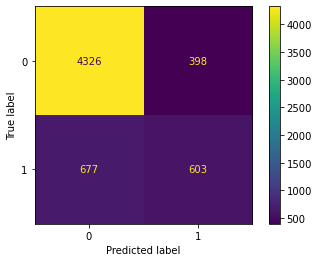

In [225]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [268]:
## 단일 모델로 여러개의 표본 학습

epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001
model = RNN_Model(learning_rate)
list_index = 0

for (j, sample) in enumerate(sampling_list):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    length = len(X_train_preprocessing)
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 10)
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (19196, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
600/600 [==============================] - 10s 17ms/step - loss: 0.6062 - auc: 0.5635 - accuracy: 0.5956 - val_loss: 0.5833 - val_auc: 0.5443 - val_accuracy: 0.6133
Epoch 2/100
600/600 [==============================] - 10s 17ms/step - loss: 0.5599 - auc: 0.5644 - accuracy: 0.6467 - val_loss: 0.5507 - val_auc: 0.5833 - val_accuracy: 0.6625
Epoch 3/100
600/600 [==============================] - 10s 17ms/step - loss: 0.5479 - auc: 0.5832 - accuracy: 0.6605 - val_loss: 0.5442 - val_auc: 0.5922 - val_accuracy: 0.6633
Epoch 4/100
600/600 [==============================] - 10s 16ms/step - loss: 0.5437 - auc: 0.5974 - accuracy: 0.6716 - val_loss: 0.5348 - val_auc: 0.6115 - val_accuracy: 0.6837
Epoch 5/100
600/600 [==============================] - 10s 16ms/step - loss: 0.5362 - auc: 0.6112 - accuracy: 0.6794 - val_loss: 0.5313 - val_auc: 0

600/600 [==============================] - 10s 16ms/step - loss: 0.4451 - auc: 0.8193 - accuracy: 0.8097 - val_loss: 0.4444 - val_auc: 0.8277 - val_accuracy: 0.8156
Epoch 93/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4445 - auc: 0.8192 - accuracy: 0.8103 - val_loss: 0.4452 - val_auc: 0.8318 - val_accuracy: 0.8167
Epoch 94/100
600/600 [==============================] - 9s 16ms/step - loss: 0.4459 - auc: 0.8206 - accuracy: 0.8079 - val_loss: 0.4435 - val_auc: 0.8272 - val_accuracy: 0.8173
Epoch 95/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4445 - auc: 0.8199 - accuracy: 0.8095 - val_loss: 0.4441 - val_auc: 0.8310 - val_accuracy: 0.8152
Epoch 96/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4445 - auc: 0.8215 - accuracy: 0.8102 - val_loss: 0.4438 - val_auc: 0.8313 - val_accuracy: 0.8144
Epoch 97/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4449 - auc: 0.8213 - accuracy: 0.8078 - val_

676/676 [==============================] - 11s 16ms/step - loss: 0.5192 - auc: 0.7920 - accuracy: 0.7620 - val_loss: 0.4463 - val_auc: 0.8509 - val_accuracy: 0.8148
Epoch 2/100
676/676 [==============================] - 11s 16ms/step - loss: 0.5162 - auc: 0.7911 - accuracy: 0.7646 - val_loss: 0.4473 - val_auc: 0.8472 - val_accuracy: 0.8148
Epoch 3/100
676/676 [==============================] - 11s 16ms/step - loss: 0.5155 - auc: 0.7911 - accuracy: 0.7664 - val_loss: 0.4475 - val_auc: 0.8502 - val_accuracy: 0.8131
Epoch 4/100
676/676 [==============================] - 11s 16ms/step - loss: 0.5142 - auc: 0.7923 - accuracy: 0.7660 - val_loss: 0.4565 - val_auc: 0.8451 - val_accuracy: 0.8121
Epoch 5/100
676/676 [==============================] - 11s 16ms/step - loss: 0.5144 - auc: 0.7909 - accuracy: 0.7652 - val_loss: 0.4500 - val_auc: 0.8487 - val_accuracy: 0.8125
Epoch 6/100
676/676 [==============================] - 11s 16ms/step - loss: 0.5136 - auc: 0.7921 - accuracy: 0.7663 - val_loss

In [269]:
print("Predicting...")

y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
y_pred = np.argmax(y_proba, axis = 1)

precision, recall, f1, accuracy = f1_score(y_val, y_pred)
print("The model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(precision, recall, f1, accuracy))

Predicting...
The model's  Precision : 0.56  Recall : 0.49  F1-score : 0.52  Accuracy: 0.80 



In [272]:
y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
y_pred = np.argmax(y_proba, axis = 1)

In [273]:
precision, recall, f1,accuracy = f1_score(y_test, y_pred)
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.58, Recall: 0.53, F1-Score: 0.55, Accuracy: 0.82


In [274]:
## 각각의 모델로 각각의 표본 학습 

epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001
list_index = 0

for (j, sample) in enumerate(sampling_list):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    length = len(X_train_preprocessing)
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model = RNN_Model(learning_rate)
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 10)
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (19196, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
600/600 [==============================] - 11s 19ms/step - loss: 0.6243 - auc: 0.6329 - accuracy: 0.6234 - val_loss: 0.5855 - val_auc: 0.5744 - val_accuracy: 0.6567
Epoch 2/100
600/600 [==============================] - 10s 16ms/step - loss: 0.5663 - auc: 0.5936 - accuracy: 0.6647 - val_loss: 0.5519 - val_auc: 0.6057 - val_accuracy: 0.6802
Epoch 3/100
600/600 [==============================] - 10s 17ms/step - loss: 0.5497 - auc: 0.6156 - accuracy: 0.6865 - val_loss: 0.5357 - val_auc: 0.6348 - val_accuracy: 0.6992
Epoch 4/100
600/600 [==============================] - 10s 16ms/step - loss: 0.5364 - auc: 0.6310 - accuracy: 0.7064 - val_loss: 0.5200 - val_auc: 0.6557 - val_accuracy: 0.7304
Epoch 5/100
600/600 [==============================] - 10s 17ms/step - loss: 0.5268 - auc: 0.6479 - accuracy: 0.7203 - val_loss: 0.5077 - val_auc: 0

600/600 [==============================] - 10s 16ms/step - loss: 0.4462 - auc: 0.8105 - accuracy: 0.8072 - val_loss: 0.4446 - val_auc: 0.8161 - val_accuracy: 0.8121
Epoch 93/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4476 - auc: 0.8085 - accuracy: 0.8068 - val_loss: 0.4449 - val_auc: 0.8174 - val_accuracy: 0.8108
Epoch 94/100
600/600 [==============================] - 9s 16ms/step - loss: 0.4466 - auc: 0.8104 - accuracy: 0.8057 - val_loss: 0.4456 - val_auc: 0.8162 - val_accuracy: 0.8119
Epoch 95/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4447 - auc: 0.8115 - accuracy: 0.8067 - val_loss: 0.4448 - val_auc: 0.8165 - val_accuracy: 0.8110s: 0.4417 - auc: 0 - ETA: 0s - loss: 0.4418 - auc: 0.813
Epoch 96/100
600/600 [==============================] - 10s 16ms/step - loss: 0.4471 - auc: 0.8093 - accuracy: 0.8075 - val_loss: 0.4465 - val_auc: 0.8146 - val_accuracy: 0.8117
Epoch 97/100
600/600 [==============================] - 10s 17ms/ste

Epoch 37/100
616/616 [==============================] - 11s 17ms/step - loss: 0.4694 - auc: 0.7868 - accuracy: 0.7911 - val_loss: 0.4481 - val_auc: 0.8021 - val_accuracy: 0.8098
Epoch 38/100
616/616 [==============================] - 12s 19ms/step - loss: 0.4684 - auc: 0.7863 - accuracy: 0.7926 - val_loss: 0.4472 - val_auc: 0.8020 - val_accuracy: 0.8090
Epoch 39/100
616/616 [==============================] - 11s 18ms/step - loss: 0.4679 - auc: 0.7876 - accuracy: 0.7921 - val_loss: 0.4499 - val_auc: 0.8032 - val_accuracy: 0.8075
Epoch 40/100
616/616 [==============================] - 11s 18ms/step - loss: 0.4678 - auc: 0.7892 - accuracy: 0.7906 - val_loss: 0.4485 - val_auc: 0.8024 - val_accuracy: 0.8094
Epoch 41/100
616/616 [==============================] - 11s 18ms/step - loss: 0.4672 - auc: 0.7890 - accuracy: 0.7917 - val_loss: 0.4463 - val_auc: 0.8048 - val_accuracy: 0.8090
Epoch 42/100
616/616 [==============================] - 11s 18ms/step - loss: 0.4668 - auc: 0.7911 - accuracy:

676/676 [==============================] - 12s 18ms/step - loss: 0.5261 - auc: 0.7800 - accuracy: 0.7574 - val_loss: 0.4630 - val_auc: 0.8263 - val_accuracy: 0.8106


Train data shape: (22589, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 4th sample
-----------------------------------------------
Epoch 1/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6695 - auc: 0.6101 - accuracy: 0.5885 - val_loss: 0.6525 - val_auc: 0.5850 - val_accuracy: 0.6185
Epoch 2/100
706/706 [==============================] - 14s 19ms/step - loss: 0.6281 - auc: 0.6221 - accuracy: 0.6650 - val_loss: 0.6215 - val_auc: 0.6448 - val_accuracy: 0.6706
Epoch 3/100
706/706 [==============================] - 12s 18ms/step - loss: 0.6109 - auc: 0.6705 - accuracy: 0.6906 - val_loss: 0.5898 - val_auc: 0.6990 - val_accuracy: 0.7229s: 0.6114 - auc: 0.6
Epoch 4/100
706/706 [==============================] - 11s 16ms/step - loss: 0.5982 - auc: 0.6956 - accuracy: 0.7098 - val_loss: 0.5734 - 

766/766 [==============================] - 13s 17ms/step - loss: 0.5949 - auc: 0.6920 - accuracy: 0.7024 - val_loss: 0.5418 - val_auc: 0.7526 - val_accuracy: 0.7763
Epoch 7/100
766/766 [==============================] - 13s 16ms/step - loss: 0.5896 - auc: 0.7038 - accuracy: 0.7081 - val_loss: 0.5438 - val_auc: 0.7533 - val_accuracy: 0.7790
Epoch 8/100
766/766 [==============================] - 12s 16ms/step - loss: 0.5856 - auc: 0.7157 - accuracy: 0.7107 - val_loss: 0.5329 - val_auc: 0.7781 - val_accuracy: 0.7962
Epoch 9/100
766/766 [==============================] - 13s 17ms/step - loss: 0.5826 - auc: 0.7245 - accuracy: 0.7146 - val_loss: 0.5278 - val_auc: 0.7919 - val_accuracy: 0.7910
Epoch 10/100
766/766 [==============================] - 13s 16ms/step - loss: 0.5804 - auc: 0.7315 - accuracy: 0.7144 - val_loss: 0.5206 - val_auc: 0.7957 - val_accuracy: 0.7987- auc: - ETA: 0s - loss: 0.579
Epoch 11/100
766/766 [==============================] - 13s 17ms/step - loss: 0.5795 - auc: 0.73

In [275]:
# f1-score
for (i, sample) in enumerate(sampling_list):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 62.57  Recall : 39.03  F1-score : 0.48  Accuracy: 0.81 

Predicting the 1th model
1th model's  Precision : 63.36  Recall : 36.32  F1-score : 0.46  Accuracy: 0.81 

Predicting the 2th model
2th model's  Precision : 62.64  Recall : 37.25  F1-score : 0.47  Accuracy: 0.81 

Predicting the 3th model
3th model's  Precision : 62.67  Recall : 39.03  F1-score : 0.48  Accuracy: 0.81 

Predicting the 4th model
4th model's  Precision : 58.71  Recall : 45.00  F1-score : 0.51  Accuracy: 0.81 

Predicting the 5th model
5th model's  Precision : 62.50  Recall : 41.08  F1-score : 0.50  Accuracy: 0.81 

Predicting the 6th model
6th model's  Precision : 56.07  Recall : 48.27  F1-score : 0.52  Accuracy: 0.80 



In [285]:
proba_list = np.array([.0] * (len(X_val_preprocessing) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [286]:
precision, recall, f1,accuracy = f1_score(y_val, y_pred)
print("VALIDATION SET")
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

VALIDATION SET
Precision: 0.62, Recall: 0.41, F1-Score: 0.50, Accuracy: 0.81


In [288]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [290]:
precision, recall, f1,accuracy = f1_score(y_test, y_pred)
print("TEST SET")
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

TEST SET
Precision: 0.62, Recall: 0.45, F1-Score: 0.52, Accuracy: 0.82


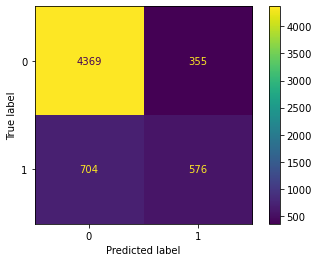

In [283]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## default의 비율이 0.4%가 되도록 뽑는다.

In [246]:
sample_size = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
sampling_list = []

for (i, size) in enumerate(sample_size):
    if size == 0:    
        df = load_sampling(split_train, size, return_default = True)
    else:
        df = load_sampling(split_train, size)
    
    X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing = preprocessing(df)
    
    sampling_list.append([X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing])

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [250]:
epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001

for (j, sample) in enumerate(sampling_list):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model = RNN_Model(learning_rate)
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32)
    
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (22589, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
706/706 [==============================] - 14s 20ms/step - loss: 0.6764 - auc: 0.5298 - accuracy: 0.5619 - val_loss: 0.6268 - val_auc: 0.5737 - val_accuracy: 0.6183
Epoch 2/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6393 - auc: 0.5662 - accuracy: 0.6059 - val_loss: 0.5955 - val_auc: 0.5936 - val_accuracy: 0.6506
Epoch 3/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6274 - auc: 0.5736 - accuracy: 0.6252 - val_loss: 0.5840 - val_auc: 0.6013 - val_accuracy: 0.6710 loss: 0.6274 - auc: 0.5735 - accura
Epoch 4/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6214 - auc: 0.5812 - accuracy: 0.6342 - val_loss: 0.5789 - val_auc: 0.6130 - val_accuracy: 0.6704
Epoch 5/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6179 - auc: 0.5899 - accuracy: 0.

706/706 [==============================] - 13s 18ms/step - loss: 0.6100 - auc: 0.6554 - accuracy: 0.6846 - val_loss: 0.5603 - val_auc: 0.7295 - val_accuracy: 0.7592
Epoch 12/100
706/706 [==============================] - 13s 18ms/step - loss: 0.6039 - auc: 0.6842 - accuracy: 0.6954 - val_loss: 0.5581 - val_auc: 0.7557 - val_accuracy: 0.7654
Epoch 13/100
706/706 [==============================] - 13s 18ms/step - loss: 0.5988 - auc: 0.7103 - accuracy: 0.7019 - val_loss: 0.5361 - val_auc: 0.7916 - val_accuracy: 0.7871
Epoch 14/100
706/706 [==============================] - 13s 18ms/step - loss: 0.5953 - auc: 0.7224 - accuracy: 0.7072 - val_loss: 0.5382 - val_auc: 0.7983 - val_accuracy: 0.7912
Epoch 15/100
706/706 [==============================] - 15s 21ms/step - loss: 0.5912 - auc: 0.7317 - accuracy: 0.7086 - val_loss: 0.5247 - val_auc: 0.8109 - val_accuracy: 0.7977
Epoch 16/100
706/706 [==============================] - 16s 23ms/step - loss: 0.5896 - auc: 0.7352 - accuracy: 0.7082 - val

706/706 [==============================] - 14s 20ms/step - loss: 0.6286 - auc: 0.5901 - accuracy: 0.6346 - val_loss: 0.5886 - val_auc: 0.6177 - val_accuracy: 0.6642
Epoch 11/100
706/706 [==============================] - 14s 20ms/step - loss: 0.6239 - auc: 0.5996 - accuracy: 0.6447 - val_loss: 0.5767 - val_auc: 0.6345 - val_accuracy: 0.7144
Epoch 12/100
706/706 [==============================] - 14s 20ms/step - loss: 0.6207 - auc: 0.6081 - accuracy: 0.6531 - val_loss: 0.5763 - val_auc: 0.6435 - val_accuracy: 0.7208
Epoch 13/100
706/706 [==============================] - 13s 19ms/step - loss: 0.6153 - auc: 0.6203 - accuracy: 0.6680 - val_loss: 0.5727 - val_auc: 0.6561 - val_accuracy: 0.7250
Epoch 14/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6103 - auc: 0.6367 - accuracy: 0.6756 - val_loss: 0.5614 - val_auc: 0.6801 - val_accuracy: 0.7342
Epoch 15/100
706/706 [==============================] - 12s 17ms/step - loss: 0.6051 - auc: 0.6544 - accuracy: 0.6910 - val

In [251]:
# f1-score
for (i, sample) in enumerate(sampling_list):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 60.03  Recall : 34.08  F1-score : 0.43  Accuracy: 0.80 

Predicting the 1th model
1th model's  Precision : 59.71  Recall : 30.72  F1-score : 0.41  Accuracy: 0.80 

Predicting the 2th model
2th model's  Precision : 60.07  Recall : 31.19  F1-score : 0.41  Accuracy: 0.80 

Predicting the 3th model
3th model's  Precision : 58.75  Recall : 34.17  F1-score : 0.43  Accuracy: 0.80 

Predicting the 4th model
4th model's  Precision : 60.99  Recall : 28.76  F1-score : 0.39  Accuracy: 0.80 

Predicting the 5th model
5th model's  Precision : 58.35  Recall : 34.27  F1-score : 0.43  Accuracy: 0.80 



In [252]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [253]:
precision, recall, f1, accuracy = f1_score(y_test, y_pred)

In [254]:
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.59, Recall: 0.32, F1-Score: 0.42, Accuracy: 0.81


## default의 비율이 0.5%가 되도록 뽑는다.

In [293]:
sample_size = [0.5] * 6
sampling_list_5 = []

for (i, size) in enumerate(sample_size):
    if size == 0:    
        df = load_sampling(split_train, size, return_default = True)
    else:
        df = load_sampling(split_train, size)
    
    X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing = preprocessing(df)
    
    sampling_list_5.append([X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing])

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [294]:
## 각각의 모델로 각각의 표본 학습 

epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001
list_index = 0

for (j, sample) in enumerate(sampling_list_5):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    length = len(X_train_preprocessing)
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model = RNN_Model(learning_rate)
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 10)
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (24509, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
766/766 [==============================] - 13s 17ms/step - loss: 0.6623 - auc: 0.6402 - accuracy: 0.6104 - val_loss: 0.6042 - val_auc: 0.6632 - val_accuracy: 0.6929
Epoch 2/100
766/766 [==============================] - 12s 16ms/step - loss: 0.6112 - auc: 0.6704 - accuracy: 0.6855 - val_loss: 0.5971 - val_auc: 0.6804 - val_accuracy: 0.7077
Epoch 3/100
766/766 [==============================] - 12s 16ms/step - loss: 0.6010 - auc: 0.6922 - accuracy: 0.7020 - val_loss: 0.5708 - val_auc: 0.7303 - val_accuracy: 0.7496
Epoch 4/100
766/766 [==============================] - 12s 16ms/step - loss: 0.5928 - auc: 0.7143 - accuracy: 0.7128 - val_loss: 0.5506 - val_auc: 0.7656 - val_accuracy: 0.8017
Epoch 5/100
766/766 [==============================] - 13s 17ms/step - loss: 0.5879 - auc: 0.7277 - accuracy: 0.7208 - val_loss: 0.5410 - val_auc: 0

766/766 [==============================] - 16s 21ms/step - loss: 0.5834 - auc: 0.7301 - accuracy: 0.7174 - val_loss: 0.5105 - val_auc: 0.8047 - val_accuracy: 0.8048
Epoch 11/100
766/766 [==============================] - 13s 17ms/step - loss: 0.5800 - auc: 0.7367 - accuracy: 0.7211 - val_loss: 0.5142 - val_auc: 0.8058 - val_accuracy: 0.8071
Epoch 12/100
766/766 [==============================] - 12s 16ms/step - loss: 0.5799 - auc: 0.7408 - accuracy: 0.7193 - val_loss: 0.5030 - val_auc: 0.8194 - val_accuracy: 0.8098
Epoch 13/100
766/766 [==============================] - 12s 16ms/step - loss: 0.5783 - auc: 0.7436 - accuracy: 0.7220 - val_loss: 0.5115 - val_auc: 0.8124 - val_accuracy: 0.8079
Epoch 14/100
766/766 [==============================] - 14s 18ms/step - loss: 0.5769 - auc: 0.7445 - accuracy: 0.7227 - val_loss: 0.4980 - val_auc: 0.8222 - val_accuracy: 0.8106
Epoch 15/100
766/766 [==============================] - 11s 15ms/step - loss: 0.5753 - auc: 0.7459 - accuracy: 0.7216 - val

766/766 [==============================] - 14s 18ms/step - loss: 0.5607 - auc: 0.7608 - accuracy: 0.7334 - val_loss: 0.5050 - val_auc: 0.8145 - val_accuracy: 0.7910s: 0.5576  -
Epoch 31/100
766/766 [==============================] - 15s 19ms/step - loss: 0.5592 - auc: 0.7601 - accuracy: 0.7352 - val_loss: 0.5025 - val_auc: 0.8154 - val_accuracy: 0.7927
Epoch 32/100
766/766 [==============================] - 15s 19ms/step - loss: 0.5604 - auc: 0.7600 - accuracy: 0.7344 - val_loss: 0.5031 - val_auc: 0.8135 - val_accuracy: 0.7925
Epoch 33/100
766/766 [==============================] - 14s 18ms/step - loss: 0.5596 - auc: 0.7605 - accuracy: 0.7357 - val_loss: 0.5031 - val_auc: 0.8159 - val_accuracy: 0.7925
Epoch 34/100
766/766 [==============================] - 14s 18ms/step - loss: 0.5581 - auc: 0.7613 - accuracy: 0.7343 - val_loss: 0.5145 - val_auc: 0.8066 - val_accuracy: 0.7896
Epoch 35/100
766/766 [==============================] - 14s 19ms/step - loss: 0.5588 - auc: 0.7608 - accuracy: 

In [295]:
# f1-score
for (i, sample) in enumerate(sampling_list_5):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 57.85  Recall : 45.75  F1-score : 0.51  Accuracy: 0.80 

Predicting the 1th model
1th model's  Precision : 59.30  Recall : 44.07  F1-score : 0.51  Accuracy: 0.81 

Predicting the 2th model
2th model's  Precision : 56.51  Recall : 46.59  F1-score : 0.51  Accuracy: 0.80 

Predicting the 3th model
3th model's  Precision : 61.19  Recall : 41.36  F1-score : 0.49  Accuracy: 0.81 

Predicting the 4th model
4th model's  Precision : 58.14  Recall : 44.35  F1-score : 0.50  Accuracy: 0.80 

Predicting the 5th model
5th model's  Precision : 54.47  Recall : 48.93  F1-score : 0.52  Accuracy: 0.79 



In [296]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [297]:
precision, recall, f1, accuracy = f1_score(y_test, y_pred)
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.60, Recall: 0.49, F1-Score: 0.54, Accuracy: 0.82


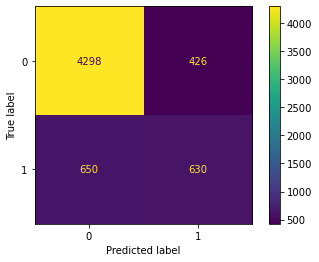

In [298]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## default가 succeed와 같은 수가 되도록 뽑는다.

In [14]:
sample_size = ["same"] * 10
sampling_list_half = []

for (i, size) in enumerate(sample_size):
    if size == 0:    
        df = load_sampling(split_train, size, return_default = True)
    else:
        df = load_sampling(split_train, 0, size)
    
    X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing = preprocessing(df)
    
    sampling_list_half.append([X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing])

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [307]:
## 각각의 모델로 각각의 표본 학습 

epochs = 100
plot_list = []
model_list = []
learning_rate = 0.00001
list_index = 0

for (j, sample) in enumerate(sampling_list_half):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model = RNN_Model(learning_rate)
    epoch, hist = train_model(model, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 20)
    model_list.append(model)
    plot_list.append([epoch, hist])
    
    print("\n")

Train data shape: (29822, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
932/932 [==============================] - 18s 19ms/step - loss: 0.6520 - auc: 0.6305 - accuracy: 0.6054 - val_loss: 0.6292 - val_auc: 0.6532 - val_accuracy: 0.7017s: 0.6524 - auc: 0.6303 - accu
Epoch 2/100
932/932 [==============================] - 18s 19ms/step - loss: 0.6237 - auc: 0.6517 - accuracy: 0.6491 - val_loss: 0.6200 - val_auc: 0.7042 - val_accuracy: 0.7485
Epoch 3/100
932/932 [==============================] - 17s 19ms/step - loss: 0.6180 - auc: 0.6591 - accuracy: 0.6579 - val_loss: 0.6317 - val_auc: 0.6951 - val_accuracy: 0.7069
Epoch 4/100
932/932 [==============================] - 16s 18ms/step - loss: 0.6157 - auc: 0.6640 - accuracy: 0.6638 - val_loss: 0.6114 - val_auc: 0.7261 - val_accuracy: 0.7502
Epoch 5/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6122 - auc: 0.6708 - accuracy: 0.6677 -

932/932 [==============================] - 16s 17ms/step - loss: 0.6150 - auc: 0.6483 - accuracy: 0.6557 - val_loss: 0.6220 - val_auc: 0.6816 - val_accuracy: 0.7094
Epoch 5/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6104 - auc: 0.6493 - accuracy: 0.6616 - val_loss: 0.6126 - val_auc: 0.6928 - val_accuracy: 0.7250
Epoch 6/100
932/932 [==============================] - 17s 18ms/step - loss: 0.6074 - auc: 0.6501 - accuracy: 0.6668 - val_loss: 0.6056 - val_auc: 0.6961 - val_accuracy: 0.7450
Epoch 7/100
932/932 [==============================] - 15s 16ms/step - loss: 0.6065 - auc: 0.6451 - accuracy: 0.6619 - val_loss: 0.5996 - val_auc: 0.7020 - val_accuracy: 0.7688
Epoch 8/100
932/932 [==============================] - 17s 18ms/step - loss: 0.6029 - auc: 0.6514 - accuracy: 0.6698 - val_loss: 0.5991 - val_auc: 0.6942 - val_accuracy: 0.7548
Epoch 9/100
932/932 [==============================] - 19s 20ms/step - loss: 0.6008 - auc: 0.6512 - accuracy: 0.6715 - val_loss

932/932 [==============================] - 16s 17ms/step - loss: 0.6067 - auc: 0.6791 - accuracy: 0.6722 - val_loss: 0.6413 - val_auc: 0.6852 - val_accuracy: 0.6954
Epoch 12/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6059 - auc: 0.6813 - accuracy: 0.6726 - val_loss: 0.6219 - val_auc: 0.7120 - val_accuracy: 0.7260
Epoch 13/100
932/932 [==============================] - 17s 18ms/step - loss: 0.6047 - auc: 0.6814 - accuracy: 0.6752 - val_loss: 0.6489 - val_auc: 0.6744 - val_accuracy: 0.6796
Epoch 14/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6026 - auc: 0.6827 - accuracy: 0.6758 - val_loss: 0.6256 - val_auc: 0.7059 - val_accuracy: 0.7250
Epoch 15/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6009 - auc: 0.6853 - accuracy: 0.6781 - val_loss: 0.6289 - val_auc: 0.6979 - val_accuracy: 0.7146
Epoch 16/100
932/932 [==============================] - 16s 17ms/step - loss: 0.6014 - auc: 0.6857 - accuracy: 0.6799 - val

932/932 [==============================] - 15s 16ms/step - loss: 0.6091 - auc: 0.6529 - accuracy: 0.6682 - val_loss: 0.6003 - val_auc: 0.7184 - val_accuracy: 0.7675
Epoch 4/100
932/932 [==============================] - 15s 16ms/step - loss: 0.6039 - auc: 0.6659 - accuracy: 0.6744 - val_loss: 0.6025 - val_auc: 0.7141 - val_accuracy: 0.7508
Epoch 5/100
932/932 [==============================] - 15s 16ms/step - loss: 0.6011 - auc: 0.6704 - accuracy: 0.6785 - val_loss: 0.5838 - val_auc: 0.7423 - val_accuracy: 0.7919
Epoch 6/100
932/932 [==============================] - 15s 16ms/step - loss: 0.5985 - auc: 0.6788 - accuracy: 0.6802 - val_loss: 0.5949 - val_auc: 0.7239 - val_accuracy: 0.7483
Epoch 7/100
932/932 [==============================] - 15s 16ms/step - loss: 0.5965 - auc: 0.6853 - accuracy: 0.6815 - val_loss: 0.5847 - val_auc: 0.7410 - val_accuracy: 0.7885
Epoch 8/100
932/932 [==============================] - 15s 16ms/step - loss: 0.5944 - auc: 0.6902 - accuracy: 0.6838 - val_loss

In [308]:
# f1-score
for (i, sample) in enumerate(sampling_list_half):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 49.62  Recall : 49.39  F1-score : 0.50  Accuracy: 0.78 

Predicting the 1th model
1th model's  Precision : 52.15  Recall : 49.86  F1-score : 0.51  Accuracy: 0.79 

Predicting the 2th model
2th model's  Precision : 51.23  Recall : 52.66  F1-score : 0.52  Accuracy: 0.78 

Predicting the 3th model
3th model's  Precision : 47.06  Recall : 56.77  F1-score : 0.51  Accuracy: 0.76 

Predicting the 4th model
4th model's  Precision : 51.55  Recall : 49.77  F1-score : 0.51  Accuracy: 0.78 

Predicting the 5th model
5th model's  Precision : 54.36  Recall : 49.49  F1-score : 0.52  Accuracy: 0.79 

Predicting the 6th model
6th model's  Precision : 46.84  Recall : 54.62  F1-score : 0.50  Accuracy: 0.76 

Predicting the 7th model
7th model's  Precision : 53.62  Recall : 50.51  F1-score : 0.52  Accuracy: 0.79 

Predicting the 8th model
8th model's  Precision : 46.19  Recall : 57.14  F1-score : 0.51  Accuracy: 0.76 

Predicting the 9th model
9th model's 

In [310]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list)), axis = 1)

In [311]:
precision, recall, f1, accuracy = f1_score(y_test, y_pred)
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.55, Recall: 0.53, F1-Score: 0.54, Accuracy: 0.81


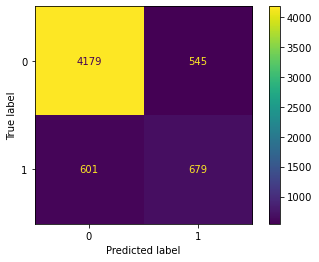

In [312]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [24]:
## 각각의 모델로 각각의 표본 학습 (patience 수정)

epochs = 100
plot_list_half_2 = []
model_list_half_2 = []
learning_rate = 0.00001 ## converge를 위해서

for (j, sample) in enumerate(sampling_list_half):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model_half_2 = RNN_Model(learning_rate)
    ## patience 10 -> 20
    epoch, hist = train_model(model_half_2, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 20)

    model_list_half_2.append(model_half_2)
    plot_list_half_2.append([epoch, hist])
    
    print("\n")

Train data shape: (29822, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 0th sample
-----------------------------------------------
Epoch 1/100
932/932 [==============================] - 6s 7ms/step - loss: 0.6719 - auc: 0.5497 - accuracy: 0.5984 - val_loss: 0.6562 - val_auc: 0.5751 - val_accuracy: 0.6371
Epoch 2/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6303 - auc: 0.6169 - accuracy: 0.6509 - val_loss: 0.6510 - val_auc: 0.6114 - val_accuracy: 0.6648
Epoch 3/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6159 - auc: 0.6491 - accuracy: 0.6659 - val_loss: 0.6363 - val_auc: 0.6391 - val_accuracy: 0.6931
Epoch 4/100
932/932 [==============================] - 6s 6ms/step - loss: 0.6100 - auc: 0.6568 - accuracy: 0.6729 - val_loss: 0.6124 - val_auc: 0.6770 - val_accuracy: 0.7369
Epoch 5/100
932/932 [==============================] - 6s 6ms/step - loss: 0.6042 - auc: 0.6690 - accuracy: 0.6756 - val_loss: 0.6288 - val_auc: 0.6581 - va

Epoch 47/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5768 - auc: 0.7297 - accuracy: 0.7030 - val_loss: 0.5914 - val_auc: 0.7268 - val_accuracy: 0.7435
Epoch 48/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5757 - auc: 0.7326 - accuracy: 0.7073 - val_loss: 0.5875 - val_auc: 0.7325 - val_accuracy: 0.7454


Train data shape: (29822, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 1th sample
-----------------------------------------------
Epoch 1/100
932/932 [==============================] - 7s 7ms/step - loss: 0.6563 - auc: 0.6110 - accuracy: 0.6144 - val_loss: 0.6515 - val_auc: 0.6196 - val_accuracy: 0.6173
Epoch 2/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6280 - auc: 0.6422 - accuracy: 0.6439 - val_loss: 0.6255 - val_auc: 0.6829 - val_accuracy: 0.6796
Epoch 3/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6207 - auc: 0.6454 - accuracy: 0.6525 - val_loss: 0.6405 - val_auc: 0.6641 

Epoch 45/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5830 - auc: 0.6667 - accuracy: 0.6973 - val_loss: 0.5720 - val_auc: 0.7297 - val_accuracy: 0.7765
Epoch 46/100
932/932 [==============================] - 5s 5ms/step - loss: 0.5817 - auc: 0.6697 - accuracy: 0.6958 - val_loss: 0.5573 - val_auc: 0.7475 - val_accuracy: 0.7879
Epoch 47/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5820 - auc: 0.6705 - accuracy: 0.6964 - val_loss: 0.5549 - val_auc: 0.7462 - val_accuracy: 0.7858
Epoch 48/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5830 - auc: 0.6702 - accuracy: 0.6964 - val_loss: 0.5909 - val_auc: 0.7076 - val_accuracy: 0.7506
Epoch 49/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5819 - auc: 0.6690 - accuracy: 0.6963 - val_loss: 0.5957 - val_auc: 0.6992 - val_accuracy: 0.7410
Epoch 50/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5817 - auc: 0.6716 - accuracy: 0.6983 - va

Epoch 25/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5875 - auc: 0.6787 - accuracy: 0.6928 - val_loss: 0.5951 - val_auc: 0.6945 - val_accuracy: 0.7579
Epoch 26/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5872 - auc: 0.6809 - accuracy: 0.6917 - val_loss: 0.5929 - val_auc: 0.7034 - val_accuracy: 0.7548
Epoch 27/100
932/932 [==============================] - 5s 5ms/step - loss: 0.5871 - auc: 0.6825 - accuracy: 0.6917 - val_loss: 0.5736 - val_auc: 0.7272 - val_accuracy: 0.7715
Epoch 28/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5844 - auc: 0.6861 - accuracy: 0.6946 - val_loss: 0.5872 - val_auc: 0.7109 - val_accuracy: 0.7660
Epoch 29/100
932/932 [==============================] - 5s 5ms/step - loss: 0.5845 - auc: 0.6855 - accuracy: 0.6960 - val_loss: 0.5804 - val_auc: 0.7179 - val_accuracy: 0.7679
Epoch 30/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5847 - auc: 0.6865 - accuracy: 0.6942 - va

932/932 [==============================] - 5s 6ms/step - loss: 0.5715 - auc: 0.7139 - accuracy: 0.7062 - val_loss: 0.5830 - val_auc: 0.7171 - val_accuracy: 0.7448
Epoch 72/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5724 - auc: 0.7139 - accuracy: 0.7057 - val_loss: 0.5822 - val_auc: 0.7144 - val_accuracy: 0.7440


Train data shape: (29822, 6, 3) Val data shape: (4800, 6, 3)
Training the model with 3th sample
-----------------------------------------------
Epoch 1/100
932/932 [==============================] - 6s 7ms/step - loss: 0.6631 - auc: 0.6119 - accuracy: 0.6156 - val_loss: 0.6242 - val_auc: 0.6904 - val_accuracy: 0.7025
Epoch 2/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6109 - auc: 0.7019 - accuracy: 0.6739 - val_loss: 0.5950 - val_auc: 0.7785 - val_accuracy: 0.7688
Epoch 3/100
932/932 [==============================] - 5s 6ms/step - loss: 0.6023 - auc: 0.7155 - accuracy: 0.6846 - val_loss: 0.5954 - val_auc: 0.7691 - val_accurac

932/932 [==============================] - 5s 6ms/step - loss: 0.5749 - auc: 0.7362 - accuracy: 0.7045 - val_loss: 0.5713 - val_auc: 0.7578 - val_accuracy: 0.7673
Epoch 20/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5741 - auc: 0.7363 - accuracy: 0.7060 - val_loss: 0.5588 - val_auc: 0.7737 - val_accuracy: 0.7725
Epoch 21/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5739 - auc: 0.7374 - accuracy: 0.7061 - val_loss: 0.5746 - val_auc: 0.7531 - val_accuracy: 0.7658
Epoch 22/100
932/932 [==============================] - 5s 5ms/step - loss: 0.5732 - auc: 0.7358 - accuracy: 0.7035 - val_loss: 0.5493 - val_auc: 0.7786 - val_accuracy: 0.7763
Epoch 23/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5726 - auc: 0.7361 - accuracy: 0.7045 - val_loss: 0.5536 - val_auc: 0.7719 - val_accuracy: 0.7735
Epoch 24/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5728 - auc: 0.7344 - accuracy: 0.7045 - val_loss: 0.562

Epoch 30/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5854 - auc: 0.7326 - accuracy: 0.6958 - val_loss: 0.5556 - val_auc: 0.7783 - val_accuracy: 0.7708
Epoch 31/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5847 - auc: 0.7332 - accuracy: 0.6973 - val_loss: 0.5641 - val_auc: 0.7725 - val_accuracy: 0.7738
Epoch 32/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5840 - auc: 0.7336 - accuracy: 0.6972 - val_loss: 0.5658 - val_auc: 0.7640 - val_accuracy: 0.7671
Epoch 33/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5839 - auc: 0.7331 - accuracy: 0.6944 - val_loss: 0.5687 - val_auc: 0.7630 - val_accuracy: 0.7663
Epoch 34/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5850 - auc: 0.7331 - accuracy: 0.6949 - val_loss: 0.5651 - val_auc: 0.7706 - val_accuracy: 0.7656
Epoch 35/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5851 - auc: 0.7341 - accuracy: 0.6970 - va

Epoch 32/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5804 - auc: 0.7198 - accuracy: 0.7015 - val_loss: 0.5543 - val_auc: 0.7727 - val_accuracy: 0.7710
Epoch 33/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5803 - auc: 0.7188 - accuracy: 0.7029 - val_loss: 0.5821 - val_auc: 0.7397 - val_accuracy: 0.7481
Epoch 34/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5787 - auc: 0.7214 - accuracy: 0.7039 - val_loss: 0.5721 - val_auc: 0.7539 - val_accuracy: 0.7635
Epoch 35/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5799 - auc: 0.7201 - accuracy: 0.7024 - val_loss: 0.5724 - val_auc: 0.7514 - val_accuracy: 0.7552
Epoch 36/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5779 - auc: 0.7199 - accuracy: 0.7047 - val_loss: 0.5535 - val_auc: 0.7704 - val_accuracy: 0.7700
Epoch 37/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5790 - auc: 0.7192 - accuracy: 0.7031 - va

Epoch 40/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5832 - auc: 0.6685 - accuracy: 0.6963 - val_loss: 0.5433 - val_auc: 0.7497 - val_accuracy: 0.7969
Epoch 41/100
932/932 [==============================] - 5s 5ms/step - loss: 0.5810 - auc: 0.6703 - accuracy: 0.6983 - val_loss: 0.5516 - val_auc: 0.7445 - val_accuracy: 0.7906
Epoch 42/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5833 - auc: 0.6698 - accuracy: 0.6963 - val_loss: 0.5402 - val_auc: 0.7489 - val_accuracy: 0.7940
Epoch 43/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5812 - auc: 0.6740 - accuracy: 0.7001 - val_loss: 0.5400 - val_auc: 0.7562 - val_accuracy: 0.7940
Epoch 44/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5813 - auc: 0.6757 - accuracy: 0.6994 - val_loss: 0.5393 - val_auc: 0.7531 - val_accuracy: 0.7900
Epoch 45/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5796 - auc: 0.6770 - accuracy: 0.7011 - va

Epoch 5/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5962 - auc: 0.6866 - accuracy: 0.6867 - val_loss: 0.5859 - val_auc: 0.7692 - val_accuracy: 0.7829
Epoch 6/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5952 - auc: 0.6873 - accuracy: 0.6875 - val_loss: 0.5745 - val_auc: 0.7784 - val_accuracy: 0.7887
Epoch 7/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5936 - auc: 0.6900 - accuracy: 0.6890 - val_loss: 0.5837 - val_auc: 0.7628 - val_accuracy: 0.7875
Epoch 8/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5919 - auc: 0.6896 - accuracy: 0.6897 - val_loss: 0.5849 - val_auc: 0.7684 - val_accuracy: 0.7819
Epoch 9/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5901 - auc: 0.6955 - accuracy: 0.6897 - val_loss: 0.5778 - val_auc: 0.7670 - val_accuracy: 0.7856
Epoch 10/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5904 - auc: 0.6952 - accuracy: 0.6907 - val_los

Epoch 11/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5941 - auc: 0.6708 - accuracy: 0.6845 - val_loss: 0.5877 - val_auc: 0.7201 - val_accuracy: 0.7906
Epoch 12/100
932/932 [==============================] - 6s 7ms/step - loss: 0.5918 - auc: 0.6723 - accuracy: 0.6859 - val_loss: 0.5865 - val_auc: 0.7261 - val_accuracy: 0.7915
Epoch 13/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5923 - auc: 0.6728 - accuracy: 0.6846 - val_loss: 0.5905 - val_auc: 0.7166 - val_accuracy: 0.7812
Epoch 14/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5923 - auc: 0.6732 - accuracy: 0.6850 - val_loss: 0.5825 - val_auc: 0.7230 - val_accuracy: 0.7892
Epoch 15/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5910 - auc: 0.6760 - accuracy: 0.6863 - val_loss: 0.5923 - val_auc: 0.7202 - val_accuracy: 0.7815
Epoch 16/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5907 - auc: 0.6770 - accuracy: 0.6862 - va

932/932 [==============================] - 6s 6ms/step - loss: 0.5773 - auc: 0.6983 - accuracy: 0.6972 - val_loss: 0.5630 - val_auc: 0.7563 - val_accuracy: 0.7735
Epoch 58/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5755 - auc: 0.7026 - accuracy: 0.6955 - val_loss: 0.5757 - val_auc: 0.7444 - val_accuracy: 0.7598
Epoch 59/100
932/932 [==============================] - 6s 6ms/step - loss: 0.5757 - auc: 0.7008 - accuracy: 0.6958 - val_loss: 0.5634 - val_auc: 0.7575 - val_accuracy: 0.7735
Epoch 60/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5758 - auc: 0.7003 - accuracy: 0.6950 - val_loss: 0.5692 - val_auc: 0.7549 - val_accuracy: 0.7704
Epoch 61/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5755 - auc: 0.7019 - accuracy: 0.6982 - val_loss: 0.5764 - val_auc: 0.7497 - val_accuracy: 0.7625
Epoch 62/100
932/932 [==============================] - 5s 6ms/step - loss: 0.5753 - auc: 0.7004 - accuracy: 0.6947 - val_loss: 0.579

In [25]:
# f1-score
for (i, sample) in enumerate(sampling_list_half):
    
    print("Predicting the {}th model".format(i))
    
    model = model_list_half_2[i]
    y_proba = model.predict([X_val_preprocessing, X_val_add_feature])
    y_pred = np.argmax(y_proba, axis = 1)
    
    precision, recall, f1, accuracy = f1_score(y_val, y_pred)
    print("{}th model's \033[35m Precision \033[30m: {:.2f} \033[35m Recall \033[30m: {:.2f} \033[35m F1-score \033[30m: {:.2f} \033[35m Accuracy\033[30m: {:.2f} \n".format(i, precision * 100, recall * 100, f1, accuracy))

Predicting the 0th model
0th model's  Precision : 46.95  Recall : 58.26  F1-score : 0.52  Accuracy: 0.76 

Predicting the 1th model
1th model's  Precision : 52.57  Recall : 50.61  F1-score : 0.52  Accuracy: 0.79 

Predicting the 2th model
2th model's  Precision : 48.18  Recall : 54.53  F1-score : 0.51  Accuracy: 0.77 

Predicting the 3th model
3th model's  Precision : 49.19  Recall : 54.06  F1-score : 0.52  Accuracy: 0.77 

Predicting the 4th model
4th model's  Precision : 50.94  Recall : 53.22  F1-score : 0.52  Accuracy: 0.78 

Predicting the 5th model
5th model's  Precision : 50.54  Recall : 52.85  F1-score : 0.52  Accuracy: 0.78 

Predicting the 6th model
6th model's  Precision : 51.92  Recall : 49.30  F1-score : 0.51  Accuracy: 0.79 

Predicting the 7th model
7th model's  Precision : 51.47  Recall : 53.97  F1-score : 0.53  Accuracy: 0.78 

Predicting the 8th model
8th model's  Precision : 53.17  Recall : 51.73  F1-score : 0.52  Accuracy: 0.79 

Predicting the 9th model
9th model's 

In [27]:
proba_list = np.array([.0] * (len(X_test) * 2)).reshape(-1, 2)

for (i, model) in enumerate(model_list_half_2):
    
    y_proba = model.predict([X_test_preprocessing, X_test_add_feature])
    proba_list += y_proba
    
y_pred = np.argmax((proba_list / len(model_list_half_2)), axis = 1)

In [29]:
precision, recall, f1, accuracy = f1_score(y_test, y_pred)
print("\033[35mPrecision\033[30m: {:.2f}, \033[35mRecall\033[30m: {:.2f}, \033[35mF1-Score\033[30m: {:.2f}, \033[35mAccuracy\033[30m: {:.2f}".format(precision, recall, f1, accuracy))

Precision: 0.53, Recall: 0.56, F1-Score: 0.54, Accuracy: 0.80


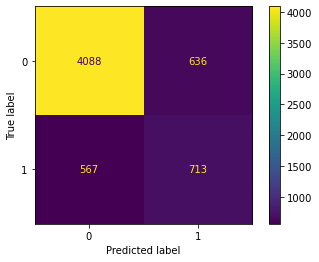

In [31]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## early stopping 의 monitor를 loss로 변경하고 학습

In [ ]:
sample_proportion =[0.5] * 10
sampling_list_5 = []

for (i, proportion) in enumerate(sample_proportion):
    df = load_sampling(split_train, proportion)
    
    X_train_preprocessing, X_train_add_feature, y_train_before, y_train_preprocessing = preprocessing(df)
    
    sampling_list_5.append([X_train_preprocessing, X_train_add_feature, y_train_preprocessing])

C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Anaconda\envs\py37tf20\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
## 각각의 모델로 각각의 표본 학습 (patience 수정)

epochs = 150
plot_list_5= []
model_list_5 = []
learning_rate = 0.00001 ## converge를 위해서

for (j, sample) in enumerate(sampling_list_5):
    
    X_train_preprocessing = sample[0]
    X_train_add_feature = sample[1]
    y_train_preprocessing = sample[3]
    
    print("Train data shape: {} Val data shape: {}".format(X_train_preprocessing.shape, X_val_preprocessing.shape))
    print("Training the model with {}th sample".format(j))
    print("-----------------------------------------------")
    
    model_5 = RNN_Model(learning_rate)
    ## patience 10 -> 20
    epoch, hist = train_model(model_half_2, [X_train_preprocessing, X_train_add_feature], y_train_preprocessing, 
                              [X_val_preprocessing, X_val_add_feature], y_val_preprocessing, epochs = epochs, batch_size = 32, patience = 15, monitor = 'val_loss')

    model_list_5.append(model_half_2)
    plot_list_5.append([epoch, hist])
    
    print("\n")